In [1]:
from IPython.display import Image, display


Display image: apple.jpeg


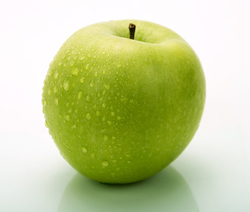


Display image: clock.jpeg


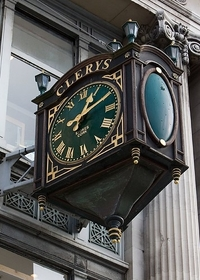


Display image: oranges.jpeg


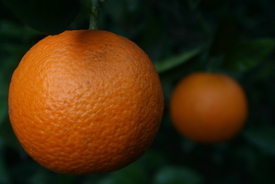


Display image: car.jpeg


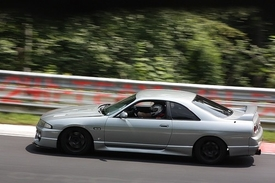

In [2]:
image_files = [
    'apple.jpeg',
    'clock.jpeg',
    'oranges.jpeg',
    'car.jpeg'
]

for image_file in image_files:
    print(f'\nDisplay image: {image_file}')
    display(Image(filename = f'../images/{image_file}'))

In [3]:
import os

dir_name = "../images_with_boxes"

if not os.path.exists(dir_name):
    os.mkdir(dir_name, exist_ok = True)

In [4]:
import cv2
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat",
    "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]

COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# Model yükle
net = cv2.dnn.readNetFromCaffe(
    "../deploy.prototxt.txt",
    "../mobilenet_iter_73000.caffemodel"
)

def detect_and_draw_box(filename, confidence_threshold=0.5):
    img_path = f"../images/{filename}"
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image not found: {img_path}")
        return

    (h, w) = image.shape[:2]

    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)),
                                 0.007843, (300, 300), 127.5)
    net.setInput(blob)
    detections = net.forward()

    print(f"=========================\nImage processed: {filename}")
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        if confidence > confidence_threshold:
            idx = int(detections[0, 0, i, 1])
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            label = f"{CLASSES[idx]}: {confidence:.2f}"
            print(f"Detected object: {label}")
            cv2.rectangle(image, (startX, startY), (endX, endY), COLORS[idx], 2)
            y = startY - 15 if startY - 15 > 15 else startY + 15
            cv2.putText(image, label, (startX, y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

    # Kaydet ve göster
    out_path = f"../images_with_boxes/{filename}"
    cv2.imwrite(out_path, image)
    display(Image(out_path))

Image processed: apple.jpeg
Detected object: pottedplant: 0.73


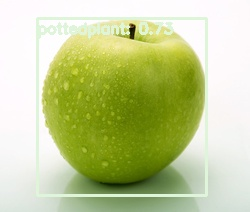

Image processed: clock.jpeg
Detected object: chair: 0.82


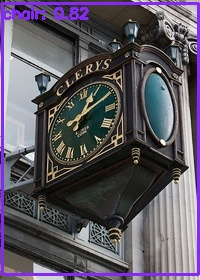

Image processed: oranges.jpeg
Detected object: bird: 0.83


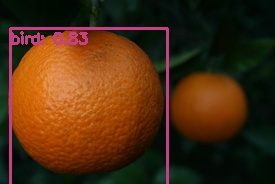

Image processed: car.jpeg
Detected object: car: 1.00


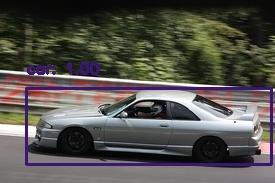

In [6]:
for image_file in image_files:
    detect_and_draw_box(image_file)

Image processed: fruits.jpeg


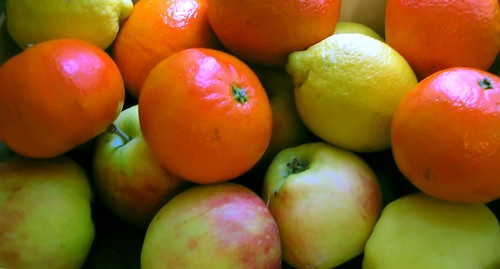

In [7]:
detect_and_draw_box("fruits.jpeg")

In [8]:
dir_name = "../images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [10]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [11]:
app = FastAPI(title = "Deploying an ML model with FastAPI")

class Model(str, Enum):
    mobilenet = "mobilenet"


#By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return {"message": "Welcome to the ML model deployment server! Now head over to the http://server/docs to see the API documentation."}


#This endpoint handles all the logic necessary for the object detection to work
#It requires the desired model and the image in which to perform object detection
@app.post("/predict")
def prediction(model: Model, file: UploadFile = File(...)):
    
    #1.Validate the input file
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_Code = 415, detail = "Unsupported file provided")

    #Transfor raw image into cv2 image
    
    #Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    #Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    #Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype = np.uint8)
    
    #Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    #3. Run object detection model
    
    #Run object detection and create a bounding box around the detected objects
    if model == Model.mobilenet:
        detect_and_draw_box(filename, confidence_threshold = 0.5)
    else:
        raise HTTPException(status_code = 400, detail = "Model not supported")
    
    # Save it in a folder within the server
    out_path = f"../images_uploaded/{filename}"
    cv2.imwrite(out_path, image)
    
    
    #Stream the response back to the client
    
    #Open the saved image for reading in binary mode
    file_image = open(out_path, "rb")
    
    #Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type = "image/jpeg", headers = {"Content-Disposition": f"attachment; filename={filename}"})
    
    

In [ ]:
#Allow the server to be run in this interactive environment
nest_asyncio.apply()

#This is an alias for the localhost which means this particular machine
host = "127.0.0.1"

#Run the server on port 8000
uvicorn.run(app, host = host, port = 8000)

INFO:     Started server process [35930]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:55368 - "GET /serve/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:55368 - "GET /serve/favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:42028 - "GET /serve/serve HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:42028 - "GET /serve/favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:34100 - "GET /serve/serve/docs HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:34100 - "GET /serve/favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:47424 - "GET /serve/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:47424 - "GET /serve/favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:37428 - "GET /serve/docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:37428 - "GET /serve/serve/openapi.json HTTP/1.1" 404 Not Found


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [35930]
